In [1]:
%matplotlib inline

In [2]:
from os import listdir
from os.path import isfile, isdir, join, exists

import opensmile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, plot_roc_curve, confusion_matrix, classification_report

Because some algorithms show too many warnings we will hide them:

In [3]:
import warnings
warnings.filterwarnings('ignore')

For reproducibility purposes, we will use this variable as a random state:

In [4]:
random_state = 54

Plt configurations:

In [5]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Parkinson's Disease Classification
## Research on voice recordings:
## Can we diagnose Parkinson's Disease based on a voice recording?
The article was developed by **Daniel Yordanov** <br>
Softuni Username: **dakataebg**

### Abstract
In this article, we used two datasets containing raw voice recordings of healthy and ill people with Parkinson's disease. We used the **Italian voice dataset** for training and testing and later tested our models additionally on the **British voice dataset**, which is smaller in size in terms of overall recordings count. We used the **Filtering feature selection method** to reduce the feature count of both datasets. We also applied **SMOTE oversampling** to the first dataset to increase its size and improve its performance. The models we used are **LogisticRegression**, **Decision Tree**, **Linear SVM**, **Gaussian SVM** and **Random Forest**. At the end of our research, we chose **Gaussian SVM** as the most adequate for practical usage in a **production environment** based on its performance on both datasets.

### Content:
1. [Introduction](#introduction)
2. [Data](#data)
3. [Extract voice features](#extract-voice-features)
4. [Conclusion](#conclusion)
5. [References](#references)

## Introduction <a id="introduction" />

Patients with Parkinson's disease (PD) may have difficulties in speaking because of reduced coordination of the muscles that control breathing, phonation, articulation, and prosody. Symptoms that may occur are weakening of the volume of the voice, voice monotony, changes in the quality of the voice, the speed of speech, uncontrolled repetition of words, and difficult speech intelligibility.

The hypothesis is that we can use this to diagnose people.

First, here is some info about the disease:
* **Information**<br>
  Parkinson’s disease is a **brain disorder** that causes **unintended or uncontrollable movements**, such as shaking, stiffness, and difficulty with balance and coordination.
  <br><br>
  Symptoms usually begin gradually and **worsen over time**. As the disease progresses, people may have difficulty **walking and talking**.
  <br><br>
  While virtually anyone could be at risk for developing Parkinson’s. It’s unclear why, but studies are underway to understand factors that may increase a person’s risk. One **clear risk is age**: Although most people with Parkinson’s first develop the disease **after age 60**, about 5% to 10% experience onset before the age of 50. Early-onset forms of Parkinson’s are often, but not always, inherited, and some forms have been linked to specific gene mutations.
  
* **What causes Parkinson’s disease?**<br>
    The most prominent signs and symptoms of Parkinson’s disease occur when **nerve cells in the basal ganglia**, an area of the brain that controls movement, become **impaired and/or die**. Normally, these nerve cells, or neurons, **produce** an important brain chemical known as **dopamine**. When the **neurons die** or become impaired, they **produce less dopamine**, which **causes the movement problems** associated with the disease. **Scientists still do not know what causes the neurons to die**.
    
    Some cases of Parkinson’s disease appear to be **hereditary**, and a few cases **can be traced to specific genetic mutations**. While **genetics** is thought to **play a role in Parkinson’s**, in most cases the disease **does not seem to run in families**. Many researchers now believe that **Parkinson’s results from a combination of genetic and environmental factors, such as exposure to toxins**.

* **Symptoms**<br>
    Parkinson’s has four main symptoms:
    *    Tremor in hands, arms, legs, jaw, or head
    *    Muscle stiffness, where muscle remains contracted for a long time
    *    Slowness of movement
    *    Impaired balance and coordination, sometimes leading to falls


* **Diagnosis**<br>
    There are currently **no blood or laboratory tests** to diagnose non-genetic cases of Parkinson’s. Doctors usually diagnose the disease by taking a person’s **medical history** and performing a **neurological examination**. If symptoms **improve** after starting to take medication, it’s another indicator that the person **has Parkinson’s**.


* **Treatments**<br>
    Although there is **no cure** for Parkinson’s disease, medicines, surgical treatment, and other **therapies can often relieve** some symptoms.

## Data <a id="data" />

The data contains voice recordings of:
- 15 healthy people aged 19–29 years including 13 men and 2 women.
- 22 healthy people aged 60–77 years including 10 men and 12 women.
- 28 patients aged 40–80 years including 19 men and 9 women.

Each voice sample will undergo feature extraction pre-processing using **OpenSMILE** (audEERING GmbH, Germany). For each voice sample, we are going to extract 6,139 voice features included in the INTERSPEECH2016 Computational Paralinguistics Challenge (IS ComParE 2016) feature dataset. To identify a subset of the most relevant features, the extracted voice features will undergo **feature selection** pre-processing using **Filter Method**. Pearson's correlation method will be applied to select voice features highly correlated with the class. As a result, redundant and irrelevant features would be removed from the original dataset. 

The following (audio-specific) low-level descriptors can be computed by openSMILE:
- Frame Energy
- Frame Intensity / Loudness (approximation)
- Critical Band spectra (Mel/Bark/Octave, triangular masking filters)
- Mel-/Bark-Frequency-Cepstral Coefficients (MFCC)
- Auditory Spectra
- Loudness approximated from auditory spectra
- Perceptual Linear Predictive (PLP) Coefficients
- Perceptual Linear Predictive Cepstral Coefficients (PLP-CC)
- Linear Predictive Coefficients (LPC)
- Line Spectral Pairs (LSP, aka. LSF)
- Fundamental Frequency (via ACF/Cepstrum method and via Subharmonic-Summation (SHS))
- Probability of Voicing from ACF and SHS spectrum peak
- Voice-Quality: Jitter and Shimmer
- Formant frequencies and bandwidths
- Zero and Mean Crossing rate
- Spectral features (arbitrary band energies, roll-off points, centroid, entropy, maxpos, minpos, variance (= spread), skewness, kurtosis, slope)
- Psychoacoustic sharpness, spectral harmonicity
- CHROMA (octave-warped semitone spectra) and CENS features (energy-normalised and smoothed CHROMA)
- CHROMA-derived features for Chord and Key recognition
- F0 Harmonics ratios

Because of the quantity of time that some operations take, we will save their product in the file system and read it on a later call.

## Extract voice features <a id="extract-voice-features" />
Here are defined the needed methods for voice features extraction.

In [6]:
def get_all_wav_files(path, audio_format):
    audio_files = []
    for item in listdir(path):
        item_path = join(path, item)
        if isfile(item_path) and item.endswith(audio_format):
            audio_files.append(item_path)
        if isdir(item_path):
            audio_files += get_all_wav_files(item_path, audio_format)
    return audio_files

In [7]:
def extract_features_from_voice_audio(audio_files):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    
    return pd.concat([smile.process_file(file) for file in audio_files])

In [8]:
# voice features dataframe contains file path and from it, we can apply a custom predicate to define a record's class 
def get_class_feature(voice_features, class_predicate_func):
    return voice_features.apply(class_predicate_func, axis=1).astype(int)

In [9]:
# binds the above features into one
def get_voice_features(audio_files_folder_path, audio_format, class_predicate_func, label):
    audio_files = get_all_wav_files(audio_files_folder_path, audio_format)
    voice_features = extract_features_from_voice_audio(audio_files)
    class_feature = get_class_feature(voice_features, class_predicate_func)
    voice_features[label] = class_feature
    return voice_features

## Read or extract voice features
Because our voice features dataset takes too long to generate, we will store it in the file system if it doesn't exist and read it from there afterwards on every execution of the article.

In [10]:
label = "class"

In [11]:
voice_features_filepath = "data/voice_features.csv"
voice_features = None

if exists(voice_features_filepath):
    voice_features = pd.read_csv(voice_features_filepath)
else:
    audio_files_folder_path = "data/Italian Parkinson's Voice and speech"
    class_predicate_func = lambda row: "Healthy" not in row.name[0]
    audio_format = ".wav"
    
    voice_features = get_voice_features(
        audio_files_folder_path, 
        audio_format,
        class_predicate_func, 
        label)
    
    voice_features.to_csv(voice_features_filepath, index=False)

In [12]:
voice_features.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,class
0,0.609272,0.397698,0.0,0.095638,0.184195,0.256760,0.088558,0.072565,0.161123,0.067810,...,0.499264,2.214003,2.213312,20.0,0.598680,99.795470,56.036830,94.244930,49.068993,0
1,0.595990,0.565840,0.0,0.092530,0.177483,0.248473,0.084952,0.070990,0.155943,0.067218,...,0.604001,2.049494,2.049888,-20.0,0.510584,91.739204,46.673950,89.658195,45.140514,0
2,0.447854,0.063291,0.0,0.071075,0.097659,0.181125,0.026584,0.083466,0.110050,0.066232,...,0.496894,1.843061,1.842053,20.0,0.598458,82.426050,42.429962,82.526550,40.629955,0
3,1.079023,0.438126,0.0,0.093635,0.221168,0.377501,0.127533,0.156333,0.283866,0.068334,...,0.510507,2.341827,2.340647,20.0,0.625501,103.660890,55.131573,104.665215,54.334373,0
4,1.082818,0.830835,0.0,0.091312,0.201476,0.332391,0.110164,0.130915,0.241080,0.069275,...,0.521455,2.349655,2.348511,20.0,0.621161,103.542915,56.521355,99.434180,51.429714,0


In [13]:
def print_shape_info(features):
    rows, cols = features.shape
    print("Records:", rows) 
    print("Features:", cols)

In [14]:
print_shape_info(voice_features)

Records: 831
Features: 6374


We have 65 unique people and different counts of samples per person. We have voice recordings of 28 ill people and 37 healthy people. The counts of records per type are:

In [15]:
def print_dataframe_records_info(features, label, healty_count, ill_count):
    records_of_healthy = (features[label] == 0).sum()
    records_of_ill = (features[label] == 1).sum()

    print("Records of healthy:", records_of_healthy)
    print("Records of ill:", records_of_ill)

    print()

    print("Records per healthy:", round(records_of_healthy / healty_count))
    print("Records per ill:", round(records_of_ill / ill_count))

In [16]:
print_dataframe_records_info(voice_features, label, 37, 28)

Records of healthy: 394
Records of ill: 437

Records per healthy: 11
Records per ill: 16


Despite having fewer ill people participating in the experiment, we have more records per person for them. That increases, the count of the overall records count of sick people becoming higher than that of healthy.

Do we have any missing cells?

In [17]:
any_missing = False
for feature_name in voice_features.columns:
    missing_cells_count = voice_features[voice_features[feature_name].isnull()].shape[0]
    if missing_cells_count > 0:
        any_missing = True
        print(feature_name, "missing cells count:", missing_cells_count)
        
if any_missing == False:
    print("No missing cells")

No missing cells


We need to check if we have other than number type of data because if we have, we must transform it.

In [18]:
print("Features unique data types:", voice_features.dtypes.unique())

Features unique data types: [dtype('float64') dtype('int64')]


That is convenient, they all are of numeric type.

## Remove irrelevant features
According to the Curse of Dimensionality, the amount of data required to build a classifier increases exponentially with the number of features. Because of that and other factors like lower computational time of the model generating algorithms and lower over-fit of the data, we will try reducing features count.

Because we only need features correlation with the class feature, we will save only this data.

In [19]:
features_corr_filepath = "data/features_corr.csv"

cor_target = None
if exists(features_corr_filepath):
    cor_target = pd.read_csv(features_corr_filepath, index_col=0)
else:
    cor = voice_features.corr()
    
    cor_target = pd.DataFrame(data={ label: cor[label].values }, index=cor.index)
    
    cor_target.to_csv(features_corr_filepath, index = True)

In [20]:
cor_target.head()

,class
audspec_lengthL1norm_sma_range,0.069029
audspec_lengthL1norm_sma_maxPos,-0.148825
audspec_lengthL1norm_sma_minPos,0.547097
audspec_lengthL1norm_sma_quartile1,0.321047
audspec_lengthL1norm_sma_quartile2,0.265786


In [21]:
#Correlation with output variable
cor_target = abs(cor_target[label])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.5]

print("Relevant features count:", len(relevant_features))
print("Relevant features names:")
relevant_features.sort_values(ascending=False)

Relevant features count: 24
Relevant features names:


class                                                1.000000
pcm_fftMag_spectralRollOff25.0_sma_amean             0.617757
pcm_zcr_sma_quartile1                                0.595594
pcm_fftMag_spectralHarmonicity_sma_minPos            0.577676
pcm_fftMag_spectralRollOff25.0_sma_percentile1.0     0.569307
pcm_fftMag_fband1000-4000_sma_de_peakMeanRel         0.551628
pcm_RMSenergy_sma_de_peakMeanRel                     0.551456
pcm_fftMag_fband1000-4000_sma_minPos                 0.547207
audspec_lengthL1norm_sma_minPos                      0.547097
pcm_fftMag_fband250-650_sma_de_peakMeanRel           0.546614
pcm_zcr_sma_percentile1.0                            0.540796
pcm_fftMag_fband250-650_sma_minPos                   0.540772
pcm_fftMag_spectralHarmonicity_sma_de_peakMeanRel    0.539835
pcm_zcr_sma_quartile2                                0.539563
pcm_RMSenergy_sma_minPos                             0.536803
pcm_fftMag_spectralRollOff50.0_sma_amean             0.534732
pcm_fftM

This is a big success, we managed to reduce from 6374 to 24 features!

### Let's analyze our data

In [22]:
def plot_two_features(x, y):
    plt.scatter(
        voice_features[x], 
        voice_features[y], 
        c=voice_features[label],
        alpha=0.6)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

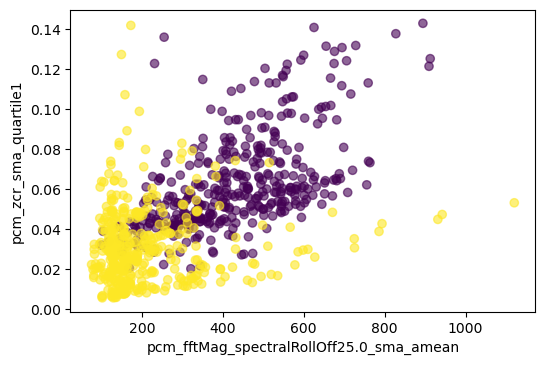

In [23]:
x = "pcm_fftMag_spectralRollOff25.0_sma_amean"
y = "pcm_zcr_sma_quartile1"

plot_two_features(x, y)

We can see that "pcm_fftMag_spectralRollOff25.0_sma_amean" and "pcm_zcr_sma_quartile1" chart is very distinctive in therms of class. 

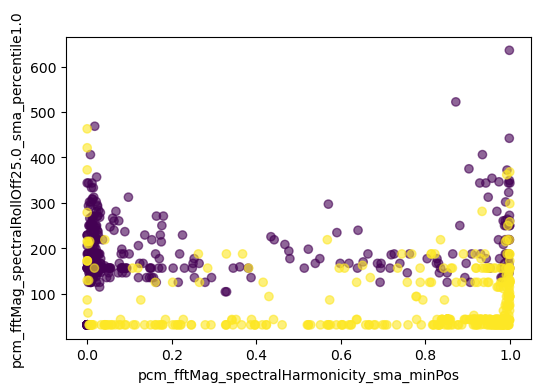

In [24]:
x = "pcm_fftMag_spectralHarmonicity_sma_minPos"
y = "pcm_fftMag_spectralRollOff25.0_sma_percentile1.0"

plot_two_features(x, y)

In "pcm_fftMag_spectralHarmonicity_sma_minPos" and "pcm_fftMag_spectralRollOff25.0_sma_percentile1.0" chart, we can distinct classes too.

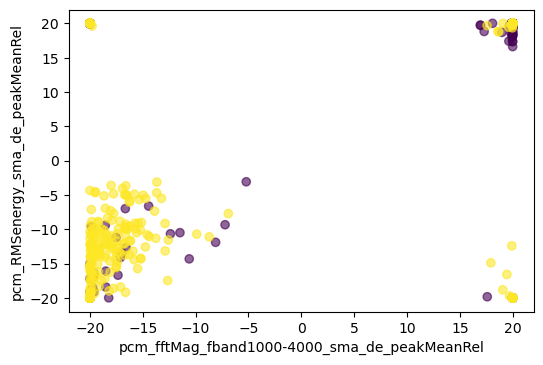

In [25]:
x = "pcm_fftMag_fband1000-4000_sma_de_peakMeanRel"
y = "pcm_RMSenergy_sma_de_peakMeanRel"

plot_two_features(x, y)

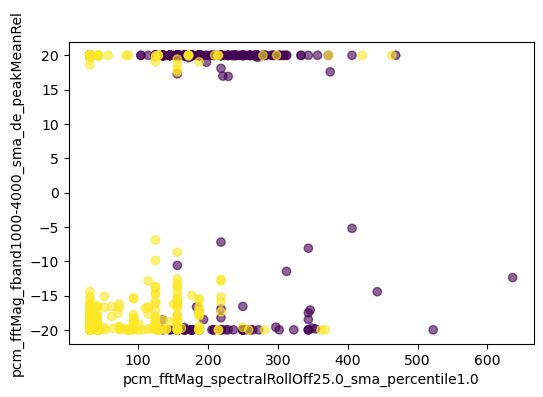

In [26]:
x = "pcm_fftMag_spectralRollOff25.0_sma_percentile1.0"
y = "pcm_fftMag_fband1000-4000_sma_de_peakMeanRel"

plot_two_features(x, y)

We saw that their differentiability lowers drastically from the first to the last. I used them in order of their correlation coefficient to the class feature.

### Use only relevant features

In [27]:
voice_features = voice_features[relevant_features.index]

### Separate features and labels

In [28]:
voice_labels = voice_features[label]
voice_features = voice_features.drop([label], axis=1)

## Preprocessing
(I tried using methods for dimensionality reduction but they lowered the scores of all models.)

After doing research for this article, I can say for sure that raw recordings are a rare thing. Because of our low count of records, I will use oversampling. It won't add hundreds of records, but it still is something.

In [29]:
current_records_count = voice_features.shape[0]
voice_features, voice_labels = SMOTE().fit_resample(voice_features, voice_labels)

In [30]:
print("Added records:", voice_features.shape[0] - current_records_count) 

Added records: 43


For better results, we will scale data in the range [0 - 1]: <br>
(I have tried using StandardScaler, but the scores were lower for most models on both datasets.)

In [31]:
scaler = MinMaxScaler()
voice_features_scaled = scaler.fit_transform(voice_features)
voice_features = pd.DataFrame(voice_features_scaled, columns = voice_features.columns)
voice_features.head()

,audspec_lengthL1norm_sma_minPos,pcm_RMSenergy_sma_minPos,pcm_zcr_sma_quartile1,pcm_zcr_sma_quartile2,pcm_zcr_sma_percentile1.0,audSpec_Rfilt_sma[24]_upleveltime25,audSpec_Rfilt_sma[25]_upleveltime25,pcm_fftMag_fband250-650_sma_minPos,pcm_fftMag_fband1000-4000_sma_minPos,pcm_fftMag_spectralRollOff25.0_sma_quartile3,...,pcm_fftMag_psySharpness_sma_percentile1.0,pcm_fftMag_spectralHarmonicity_sma_minPos,pcm_fftMag_spectralEntropy_sma_de_minPos,pcm_fftMag_spectralRollOff25.0_sma_amean,pcm_fftMag_spectralRollOff50.0_sma_amean,audspec_lengthL1norm_sma_de_peakMeanRel,pcm_RMSenergy_sma_de_peakMeanRel,pcm_fftMag_fband250-650_sma_de_peakMeanRel,pcm_fftMag_fband1000-4000_sma_de_peakMeanRel,pcm_fftMag_spectralHarmonicity_sma_de_peakMeanRel
0,0.0,0.0,0.212193,0.199366,0.065782,0.082235,0.077114,0.0,0.0,0.036100,...,0.070670,0.0,0.000523,0.108153,0.199606,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.199568,0.197613,0.017005,0.025457,0.073961,0.0,0.0,0.036100,...,0.048764,0.0,0.718965,0.099563,0.189044,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.191993,0.194105,0.016467,0.124870,0.087724,0.0,0.0,0.016750,...,0.050243,0.0,0.000436,0.023808,0.082564,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.202093,0.206382,0.002834,0.032680,0.044586,0.0,0.0,0.103825,...,0.047407,0.0,0.000501,0.224362,0.292743,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.166743,0.192351,0.000000,0.047931,0.042700,0.0,0.0,0.074800,...,0.043118,0.0,0.726853,0.209291,0.287773,1.0,1.0,1.0,1.0,1.0


# Train test split
Now we will split train and test data.

In [32]:
voice_features_train, voice_features_test, voice_labels_train, voice_labels_test = train_test_split(
    voice_features, 
    voice_labels,
    random_state=random_state,
    train_size=0.7)

# Model <a id="model" />
## Metrics
Before we jump into generating models and tuning their hyperparameters, let's create a function for showing model statistics, like how good it scores, showing the roc curve and other basic methods for evaluating a model. 

In [33]:
def print_separator(times = 2 ** 6):
    print("-" * times)

In [34]:
def print_default_score(model, features, labels):
    score = model.score(features, labels)
    print("correct predictions / all predictions:", round(score, 3))

In [35]:
k_fold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=random_state)

def show_cross_val_score(model, features, labels):
    scores = cross_val_score(model, features, labels, cv = k_fold, scoring="f1")
    scores = np.around(scores, decimals=3)
    print("cross_val_score")
    print("scores:", ", ".join(map(str, scores)))
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [36]:
def show_confusion_matrix(labels, y_pred):
    conv_matrix = confusion_matrix(labels, y_pred)
    print("confusion_matrix")
    print("True Positive:", conv_matrix[0, 0])
    print("Flase Negative:", conv_matrix[0, 1])
    print("False Positive:", conv_matrix[1, 0])
    print("True Negative:", conv_matrix[1, 1])

In [37]:
def show_roc_curve(model, features, labels):
    plot_roc_curve(model, features, labels)
    plt.title("roc curve")
    plt.show()

In [38]:
def show_classification_report(labels, y_pred):
    print("classification_report")
    print(classification_report(labels, y_pred))

In [39]:
def show_model_stats(model, features, labels):
    y_pred = model.predict(features)
    
    # Show metrics
    print_default_score(model, features, labels)
    
    print_separator()
    
    show_cross_val_score(model, features, labels)
    
    print_separator()
    
    show_confusion_matrix(labels, y_pred)
    
    print_separator()
    
    show_roc_curve(model, features, labels)
    
    print_separator()
    
    show_classification_report(labels, y_pred)

## Model generation
We will use GridSearchCV to perform hyper parameter tuning, and because it is a lot of copy-pasting for each model algorithm, we will follow DRY practice and extract it in function.

In [40]:
def use_grid_search_cv(model, tuned_params, features, labels):
    grid_search = GridSearchCV(
    model(random_state=random_state), 
    tuned_params,
    scoring="f1",
    cv=k_fold)
    
    grid_search.fit(features, labels)
    
    return grid_search.best_estimator_

## LogisticRegression

In [41]:
tuned_params = [{
    "C": [0.0001, 0.01, 0.1, 1, 10, 100, 10000],
    "max_iter": [50, 100, 300, 1000],
    "fit_intercept": [True, False]
}]

logistic_classifier = use_grid_search_cv(LogisticRegression, tuned_params, voice_features_train, voice_labels_train)

correct predictions / all predictions: 0.935
----------------------------------------------------------------
cross_val_score
scores: 0.9, 0.909, 0.929, 0.964, 0.943
0.93 accuracy with a standard deviation of 0.02
----------------------------------------------------------------
confusion_matrix
True Positive: 117
Flase Negative: 4
False Positive: 13
True Negative: 129
----------------------------------------------------------------


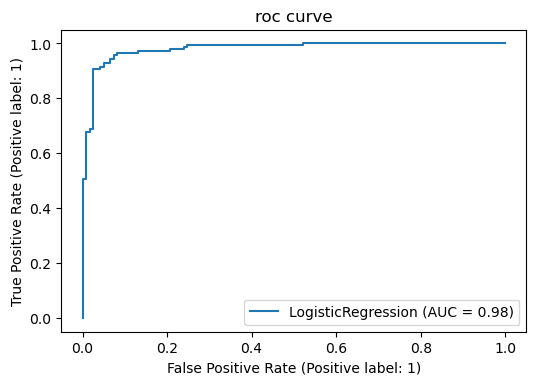

----------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       121
           1       0.97      0.91      0.94       142

    accuracy                           0.94       263
   macro avg       0.93      0.94      0.94       263
weighted avg       0.94      0.94      0.94       263



In [42]:
show_model_stats(logistic_classifier, voice_features_test, voice_labels_test)

The good side of this score is that the false positive predictions count is 14 times more than that of false negatives. That is good because we prefer to classify someone ill and a doctor to check that person from classifying him healthy, and he goes on with his daily life without concerns.

## Decision Tree

In [43]:
tuned_params = [{
    'max_depth': [1, 5, 7, 15, 20],
    'min_samples_leaf': [2, 5, 10, 12],
    'max_leaf_nodes': [5, 10, 20],
}]

tree_classifier = use_grid_search_cv(DecisionTreeClassifier, tuned_params, voice_features_train, voice_labels_train)

correct predictions / all predictions: 0.966
----------------------------------------------------------------
cross_val_score
scores: 0.949, 0.982, 0.897, 0.945, 0.912
0.94 accuracy with a standard deviation of 0.03
----------------------------------------------------------------
confusion_matrix
True Positive: 119
Flase Negative: 2
False Positive: 7
True Negative: 135
----------------------------------------------------------------


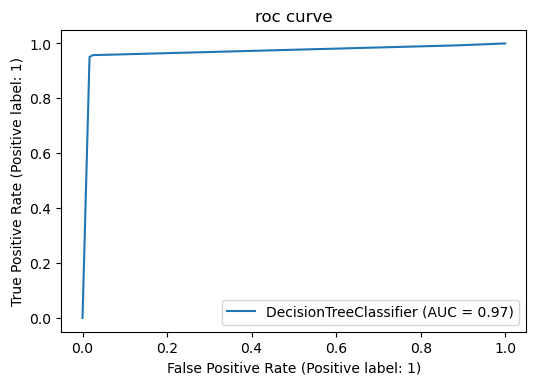

----------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       121
           1       0.99      0.95      0.97       142

    accuracy                           0.97       263
   macro avg       0.96      0.97      0.97       263
weighted avg       0.97      0.97      0.97       263



In [44]:
show_model_stats(tree_classifier, voice_features_test, voice_labels_test)

This score is higher than the one of Logistic Regression. We have to keep in mind that the false positive (FP) to false negative (FN) predictions count ratio is 1:1. This isn't bad but might become dangerous for more predictions.

## Random Forest 

In [45]:
tuned_params = [{
    'n_estimators': [100, 200, 300],
    'max_depth': [20, 50, 100],
}]

forest_classifier = use_grid_search_cv(RandomForestClassifier, tuned_params, voice_features_train, voice_labels_train)

correct predictions / all predictions: 0.973
----------------------------------------------------------------
cross_val_score
scores: 0.966, 0.929, 0.982, 0.963, 1.0
0.97 accuracy with a standard deviation of 0.02
----------------------------------------------------------------
confusion_matrix
True Positive: 119
Flase Negative: 2
False Positive: 5
True Negative: 137
----------------------------------------------------------------


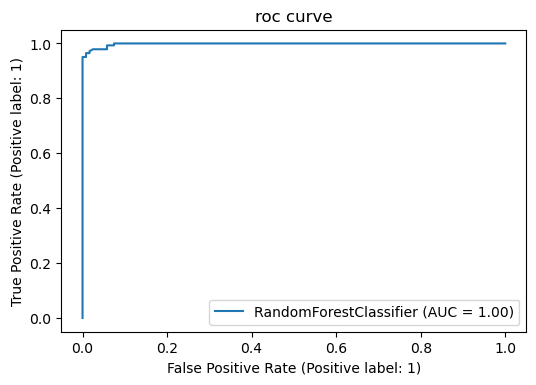

----------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       121
           1       0.99      0.96      0.98       142

    accuracy                           0.97       263
   macro avg       0.97      0.97      0.97       263
weighted avg       0.97      0.97      0.97       263



In [46]:
show_model_stats(forest_classifier, voice_features_test, voice_labels_test)

I like this score currently the most. Currently, the biggest score and the FP:FN is 2:1.

## Linear SVM

In [47]:
tuned_params = [{
    'C': [0.1, 0.5, 0.8, 1, 1.5, 2, 6, 10, 15, 20],
}]

linear_svm_classifier = use_grid_search_cv(LinearSVC, tuned_params, voice_features_train, voice_labels_train)

correct predictions / all predictions: 0.932
----------------------------------------------------------------
cross_val_score
scores: 0.931, 0.915, 0.909, 1.0, 0.909
0.93 accuracy with a standard deviation of 0.03
----------------------------------------------------------------
confusion_matrix
True Positive: 116
Flase Negative: 5
False Positive: 13
True Negative: 129
----------------------------------------------------------------


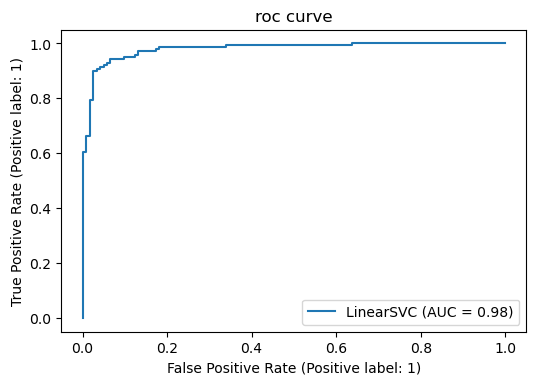

----------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       121
           1       0.96      0.91      0.93       142

    accuracy                           0.93       263
   macro avg       0.93      0.93      0.93       263
weighted avg       0.93      0.93      0.93       263



In [48]:
show_model_stats(linear_svm_classifier, voice_features_test, voice_labels_test)

It performed slightly worse than Random Forest and Decision Tree but slightly better than Logistic Regression. That's why the current top spot stays for Random Forest. 

## Gaussian SVM

In [49]:
tuned_params = [{
    'C': [10, 15, 20, 50, 200],
    'gamma': [0.001, 0.01, 0.1, 0.2],
}]

gaussian_svm_classifier = use_grid_search_cv(SVC, tuned_params, voice_features_train, voice_labels_train)

correct predictions / all predictions: 0.966
----------------------------------------------------------------
cross_val_score
scores: 0.983, 0.982, 0.966, 0.923, 0.943
0.96 accuracy with a standard deviation of 0.02
----------------------------------------------------------------
confusion_matrix
True Positive: 117
Flase Negative: 4
False Positive: 5
True Negative: 137
----------------------------------------------------------------


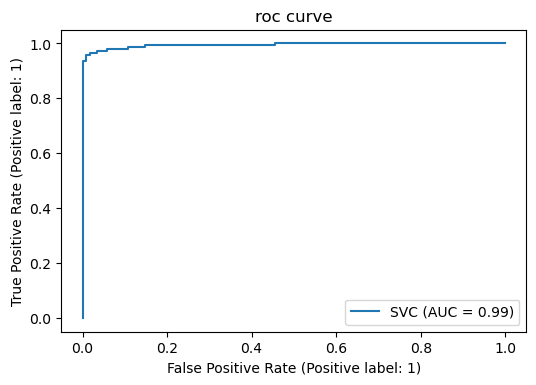

----------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       121
           1       0.97      0.96      0.97       142

    accuracy                           0.97       263
   macro avg       0.97      0.97      0.97       263
weighted avg       0.97      0.97      0.97       263



In [50]:
show_model_stats(gaussian_svm_classifier, voice_features_test, voice_labels_test)

We can say that it performed the same as Decision Tree, so it too doesn't take the top spot.


## Let's sum up our results.

In [51]:
# I am using this approach and not just calling the model's default score 
#   to be able to change the scoring method easily later 
#   if needed and this way we are lowering code repetition.

def show_all_models_score(features, labels, score_name, scoring_method_currying):
    score_current_dataset = scoring_method_currying(features, labels)

    logistic_classifier_score = score_current_dataset(logistic_classifier)
    tree_classifier_score = score_current_dataset(tree_classifier)
    forest_classifier_score = score_current_dataset(forest_classifier)
    linear_svm_classifier_score = score_current_dataset(linear_svm_classifier)
    gaussian_svm_classifier_score = score_current_dataset(gaussian_svm_classifier)
    
    print(score_name)
    print("Logistic regression:", round(logistic_classifier_score, 3))
    print("Decision tree:", round(tree_classifier_score, 3))
    print("Random forest:", round(forest_classifier_score, 3))
    print("Linear SVM:", round(linear_svm_classifier_score, 3))
    print("Gaussian SVM:", round(gaussian_svm_classifier_score, 3))

In [52]:
def f1_score_currying(features, labels):
    def score_current_dataset(model):
        return f1_score(labels, model.predict(features))
    
    return score_current_dataset

In [53]:
def default_score_currying(features, labels):
    def score_current_dataset(model):
        return model.score(features, labels)
    
    return score_current_dataset

In [54]:
show_all_models_score(voice_features_test, voice_labels_test, "f1", f1_score_currying)

f1
Logistic regression: 0.938
Decision tree: 0.968
Random forest: 0.975
Linear SVM: 0.935
Gaussian SVM: 0.968


In [55]:
show_all_models_score(voice_features_test, voice_labels_test, "correct predictions / all predictions", default_score_currying)

correct predictions / all predictions
Logistic regression: 0.935
Decision tree: 0.966
Random forest: 0.973
Linear SVM: 0.932
Gaussian SVM: 0.966


The best performance is the Random forest model, with a score very close to 100%, followed by a Decision tree and Gaussian SVM.

Let's compare Random forest and Decision tree feature importances.

In [56]:
def get_top_n_features_from_model(model, n):
    name_label = "name"
    val_label = "val"
    
    def get_coef_formated_for_dataframe(coef):
            return { name_label: voice_features.columns, val_label: abs(coef) }

    return pd.DataFrame(
        data=get_coef_formated_for_dataframe(model.feature_importances_)).nlargest(n, val_label)[name_label]

def print_matching_features_count(f1, f2, n):
    x = len(set(f1).intersection(set(f2)))
    print("From the two models the top", n, "features by weight contain", x, "matching features.")
    
def print_matching_by_order_features_count(f1, f2, n):
    count = 0
    for i in range(n):
        if f1.iloc[i] == f2.iloc[i]:
            count += 1
    print(count, "out of", n, "were in the same order by weight.") 
        
def print_models_feature_weights_stats(n):
    forest_top_features = get_top_n_features_from_model(forest_classifier, n)
    tree_top_features = get_top_n_features_from_model(tree_classifier, n)
    
    print("forest_top_features and tree_top_features")
    print_matching_features_count(forest_top_features, tree_top_features, n)
    print_matching_by_order_features_count(forest_top_features, tree_top_features, n)
    
    rf_names = relevant_features.drop(label).sort_values(ascending=False).index
    rf_names = pd.DataFrame(rf_names)[0]
    
    print_separator()
    print("forest_top_features and relevant_features_names")
    print_matching_features_count(forest_top_features, rf_names, n)
    print_matching_by_order_features_count(forest_top_features, rf_names, n)
    
    print_separator()
    print("tree_top_features and relevant_features_names")
    print_matching_features_count(rf_names, tree_top_features, n, )
    print_matching_by_order_features_count(rf_names, tree_top_features, n)

In [57]:
col_len = len(voice_features.columns)
for n in range(5, col_len, 5):
    print("n:", n)
    print_models_feature_weights_stats(n)
    print()

print("n:", col_len)
print_models_feature_weights_stats(col_len)

n: 5
forest_top_features and tree_top_features
From the two models the top 5 features by weight contain 3 matching features.
2 out of 5 were in the same order by weight.
----------------------------------------------------------------
forest_top_features and relevant_features_names
From the two models the top 5 features by weight contain 5 matching features.
1 out of 5 were in the same order by weight.
----------------------------------------------------------------
tree_top_features and relevant_features_names
From the two models the top 5 features by weight contain 5 matching features.
2 out of 5 were in the same order by weight.

n: 10
forest_top_features and tree_top_features
From the two models the top 10 features by weight contain 7 matching features.
3 out of 10 were in the same order by weight.
----------------------------------------------------------------
forest_top_features and relevant_features_names
From the two models the top 10 features by weight contain 10 matching fea

We can conclude that overall their order doesn't match and in the cases it does, it is by chance.

In [58]:
print("logistic regression top 1 feature:", get_top_n_features_from_model(forest_classifier, 1).iloc[0])
print("logistic regression top 1 feature:", get_top_n_features_from_model(tree_classifier, 1).iloc[0])
print("logistic regression top 1 feature:", relevant_features.drop(label).sort_values(ascending=False).index[0])

logistic regression top 1 feature: pcm_fftMag_spectralRollOff25.0_sma_amean
logistic regression top 1 feature: pcm_fftMag_spectralRollOff25.0_sma_amean
logistic regression top 1 feature: pcm_fftMag_spectralRollOff25.0_sma_amean


Well, at least this is interesting. We can see that pcm_fftMag_spectralRollOff25.0_sma feature type is highly valued.

# Prepare Other Dataset
We already saw how our model performs on the Italian voices dataset. To test how reliable our models are, we will predict the classes of the new dataset and choose the best model.

* **Data Info:**<br>
"The dataset was recorded at King's College London (KCL) Hospital, Denmark Hill, Brixton, London SE5 9RS in the period from 26 to 29 September 2017. We used a typical examination room with about ten square meters area and a typical reverberation tome of approx. 500ms to perform the voice recordings. Due to the fact, that the voice recordings are performed in the realistic situation of doing a phone call (i.e. participant holds the phone to the preferred ear and microphone is in direct proximity to the mouth), one can assume that all recordings were performed within the reverberation radius and thus can be considered as “clean”." [dataset and text source](https://zenodo.org/record/2867216)

We will follow the same processing steps as for the past dataset.

Read data:

In [59]:
other_voice_features_filepath = "data/test_voice_features.csv"
other_voice_features = None

if exists(other_voice_features_filepath):
    other_voice_features = pd.read_csv(other_voice_features_filepath)
else:
    audio_files_folder_path = "data/TestDataset"
    class_predicate_func = lambda row: "\\PD\\" in row.name[0]
    audio_format = ".wav"
    
    other_voice_features = get_voice_features(
        audio_files_folder_path, 
        audio_format, 
        class_predicate_func, 
        label)
    
    other_voice_features.to_csv(other_voice_features_filepath, index=False)

In [60]:
other_voice_features.head()

,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,class
0,1.068221,0.229012,0.053761,0.070124,0.142961,0.253994,0.072837,0.111032,0.183870,0.041453,...,0.469256,2.331093,2.331860,-20.0,0.674969,104.134720,52.583454,101.914300,52.154600,0
1,6.369210,0.493568,0.760166,0.081711,0.370981,0.694179,0.289270,0.323198,0.612468,0.039616,...,0.576803,2.756658,2.756342,20.0,0.532858,115.549736,64.617165,110.490590,60.798960,0
2,1.439469,0.892386,0.905793,0.089911,0.195657,0.352913,0.105746,0.157256,0.263002,0.042567,...,0.594439,2.587064,2.587113,-20.0,0.551172,107.481560,53.066254,104.894480,54.217150,0
3,1.419298,0.484889,0.700226,0.068416,0.244612,0.444998,0.176196,0.200386,0.376582,0.041061,...,0.605909,2.594225,2.594218,20.0,0.613786,111.194790,55.853540,106.426094,54.046448,0
4,2.324570,0.133192,0.444155,0.074566,0.182165,0.314206,0.107599,0.132041,0.239640,0.035791,...,0.508608,2.626891,2.626609,20.0,0.610839,108.303000,56.228000,107.749740,58.238790,0


In [61]:
print_shape_info(other_voice_features)

Records: 73
Features: 6374


In [62]:
print_dataframe_records_info(other_voice_features, label, 42, 31)

Records of healthy: 42
Records of ill: 31

Records per healthy: 1
Records per ill: 1


In this dataset, each record is for a unique person.

Use only relevant features:

In [63]:
other_voice_features = other_voice_features[relevant_features.index]

Separate class from features:

In [64]:
other_labels = other_voice_features[label]
other_voice_features = other_voice_features.drop([label], axis=1)

Preprocessing:

Scale features:

In [65]:
other_voice_features_scaled = scaler.fit_transform(other_voice_features)
other_voice_features = pd.DataFrame(other_voice_features_scaled, columns = other_voice_features.columns)

# Evaluate Other Dataset

In [66]:
show_all_models_score(other_voice_features, other_labels, "f1", f1_score_currying)

f1
Logistic regression: 0.508
Decision tree: 0.586
Random forest: 0.453
Linear SVM: 0.525
Gaussian SVM: 0.341


In [67]:
show_all_models_score(other_voice_features, other_labels, "correct predictions / all predictions", default_score_currying)

correct predictions / all predictions
Logistic regression: 0.575
Decision tree: 0.438
Random forest: 0.603
Linear SVM: 0.603
Gaussian SVM: 0.63


This time Random forest is not with the best score. The Decision tree performed the best with around 60% accuracy. That is in terms of the f1 score, but in terms of correct predictions with the highest score being of Gaussian SVM. To decide best model we need to analyze each model's stats.

(I am writing this after first executing everything without and with oversampling the data. My supervision is that our score got higher after oversampling the data not only on the Italian dataset used for training and testing but also on the unrelated British dataset used only for testing.)

Now let's see stats about each model.

**Decision Tree**

correct predictions / all predictions: 0.438
----------------------------------------------------------------
cross_val_score
scores: 0.533, 0.6, 0.714, 0.667, 0.923
0.69 accuracy with a standard deviation of 0.13
----------------------------------------------------------------
confusion_matrix
True Positive: 3
Flase Negative: 39
False Positive: 2
True Negative: 29
----------------------------------------------------------------


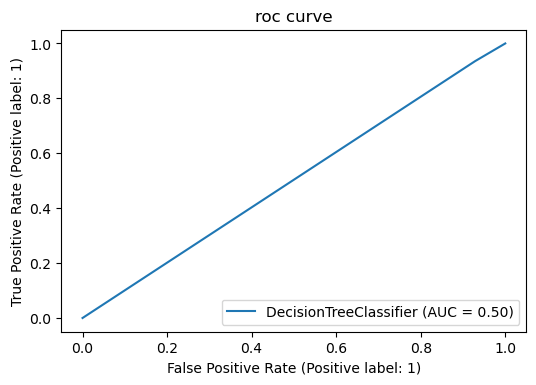

----------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.60      0.07      0.13        42
           1       0.43      0.94      0.59        31

    accuracy                           0.44        73
   macro avg       0.51      0.50      0.36        73
weighted avg       0.53      0.44      0.32        73



In [68]:
show_model_stats(tree_classifier, other_voice_features, other_labels)

Very interesting, it has only 3 positive and 81 negative predictions. That means that 96% of the time, it doesn't do anything or said in other way, mostly gives 0. I don't think those are good results at all.

**Logistic Regression:**

correct predictions / all predictions: 0.575
----------------------------------------------------------------
cross_val_score
scores: 0.667, 0.714, 0.615, 0.615, 0.706
0.66 accuracy with a standard deviation of 0.04
----------------------------------------------------------------
confusion_matrix
True Positive: 26
Flase Negative: 16
False Positive: 15
True Negative: 16
----------------------------------------------------------------


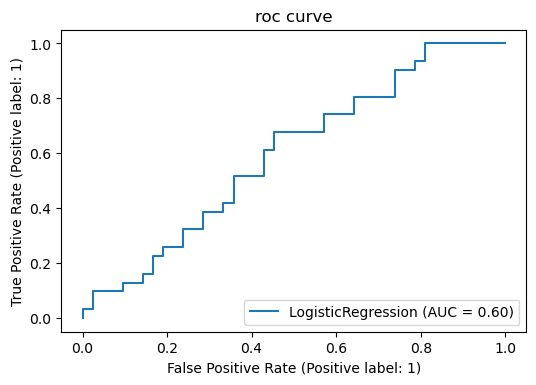

----------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.63      0.62      0.63        42
           1       0.50      0.52      0.51        31

    accuracy                           0.58        73
   macro avg       0.57      0.57      0.57        73
weighted avg       0.58      0.58      0.58        73



In [69]:
show_model_stats(logistic_classifier, other_voice_features, other_labels)

Having the second highest accuracy score and good FP:FN ratio I think it performed well.

**Linear SVM:**

correct predictions / all predictions: 0.603
----------------------------------------------------------------
cross_val_score
scores: 0.615, 0.6, 0.727, 0.615, 0.706
0.65 accuracy with a standard deviation of 0.05
----------------------------------------------------------------
confusion_matrix
True Positive: 28
Flase Negative: 14
False Positive: 15
True Negative: 16
----------------------------------------------------------------


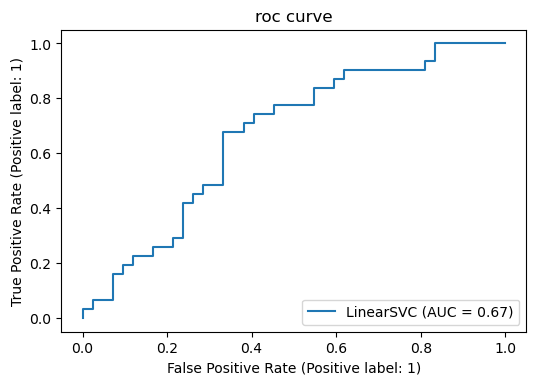

----------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.65      0.67      0.66        42
           1       0.53      0.52      0.52        31

    accuracy                           0.60        73
   macro avg       0.59      0.59      0.59        73
weighted avg       0.60      0.60      0.60        73



In [70]:
show_model_stats(linear_svm_classifier, other_voice_features, other_labels)

I would rate it currently second. With a similar FP:FN ratio and accuracy score to Logistic Regression.

**Random Forest:**

correct predictions / all predictions: 0.603
----------------------------------------------------------------
cross_val_score
scores: 0.667, 0.727, 0.833, 0.909, 1.0
0.83 accuracy with a standard deviation of 0.12
----------------------------------------------------------------
confusion_matrix
True Positive: 32
Flase Negative: 10
False Positive: 19
True Negative: 12
----------------------------------------------------------------


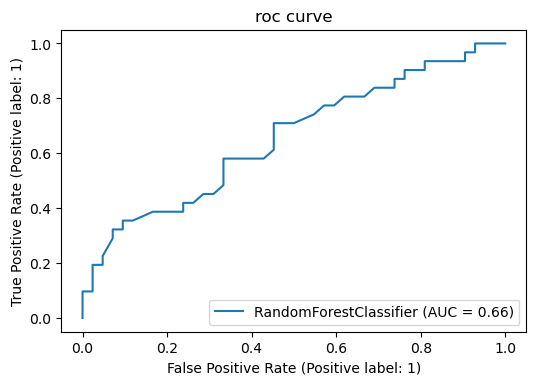

----------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.63      0.76      0.69        42
           1       0.55      0.39      0.45        31

    accuracy                           0.60        73
   macro avg       0.59      0.57      0.57        73
weighted avg       0.59      0.60      0.59        73



In [71]:
show_model_stats(forest_classifier, other_voice_features, other_labels)

It has lower accuracy but still performs well.

**Gaussian SVM:**

correct predictions / all predictions: 0.63
----------------------------------------------------------------
cross_val_score
scores: 0.571, 0.6, 0.615, 0.667, 0.769
0.64 accuracy with a standard deviation of 0.07
----------------------------------------------------------------
confusion_matrix
True Positive: 39
Flase Negative: 3
False Positive: 24
True Negative: 7
----------------------------------------------------------------


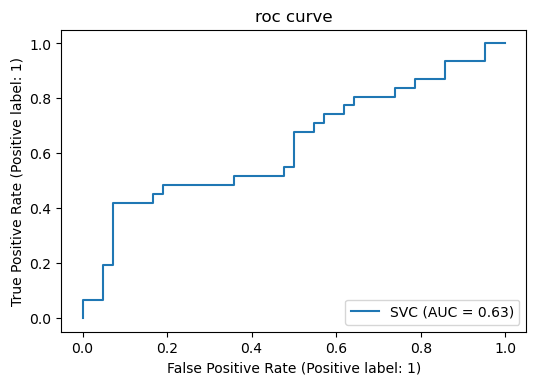

----------------------------------------------------------------
classification_report
              precision    recall  f1-score   support

           0       0.62      0.93      0.74        42
           1       0.70      0.23      0.34        31

    accuracy                           0.63        73
   macro avg       0.66      0.58      0.54        73
weighted avg       0.65      0.63      0.57        73



In [72]:
show_model_stats(gaussian_svm_classifier, other_voice_features, other_labels)

It performed the best.

## Conclusion <a id="conclusion" />
In a production environment used by real people in mobile, web or another application kind, I would choose to use the **Gaussian SVM** model.
I made this decision by excluding the other models one by one.
First, I removed the Decision Tree from my list of candidates because of its rendition to predict 0.
Second, I chose to eliminate Random forest because its roc curve is with the smallest value from the other three and with lower accuracy than them.
Third, I chose to remove the Logistic Regression because it has lower statistics than the other two, and it also performed poorer in the first dataset.
Last, I chose to eliminate Linear SVM because of its poorer scores in both datasets compared to Gaussian SVM.
I think that the difference in performance for the two datasets comes from the different conditions of recording and the different languages. After all, the first one is used Italian and the second one British.

## References <a id="references" />
Disease info: [url](https://www.nia.nih.gov/health/parkinsons-disease) <br>
Italian dataset: [url](https://ieee-dataport.org/open-access/italian-parkinsons-voice-and-speech#) <br>
British dataset: [url](https://zenodo.org/record/2867216) <br>
Articles used info from: [article1 url](https://www.frontiersin.org/articles/10.3389/fneur.2022.831428/full), [article2 url](https://ieeexplore.ieee.org/document/8070308) 